<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #10: Recommender Systems

<span style="color:blue; font-size: 12pt">Andrey Saitgalin </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'"> andrey.saitgalin@gmail.com </span>

<h1 align="center">Organization Info</h1> 

* Дедлайн **18 декабря 23:59** для всех групп.
* В качестве решения задания нужно прислать ноутбук с подробными комментариями (<span style='color:red'> без присланного решения результат контеста не будет засчитан </span>).
* <span style='color:red'>Название команды в контесте должно соответствовать шаблону: НомерГруппы_Имя_Фамилия, например, 494_Ivan_Ivanov</span>.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task10.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``


--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было.

<h1 align="center">Contest (100%)</h1> 
* Ссылка на контест: https://www.kaggle.com/t/f37413eb448145acba822f3a8c43946d

In [10]:
import numpy as np

import pandas as pd
from IPython.display import display

from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


%matplotlib inline


In [11]:
train = pd.read_csv("data/train.csv")
train.head()

,rating,movieId,userId
0,3.0,2158,10953099004185006703
1,3.5,12959,10953099004185006703
2,3.5,7808,10953099004185006703
3,4.0,9049,4762492897681260571
4,3.0,12363,2110017552365950661


In [12]:
train.userId = train.userId.astype('uint64')

In [13]:
train.head(2)

,rating,movieId,userId
0,3.0,2158,10953099004185006703
1,3.5,12959,10953099004185006703


In [14]:
display(train.size)
display(train.movieId.max())
display(len(set(train.userId)))

57043719

18345

138493

In [15]:
test = pd.read_csv("data/test.csv")
test.userId = test.userId.astype('uint64')
test.head()

,movieId,userId
0,939,3128775406573976678
1,19,6058877902987009152
2,1213,2787275058272728238
3,1141,14199414671932452776
4,2935,5958052843391945803


In [19]:
user_to_compress_id = {}
compress_to_user_id = {}

def add_id_to_compress(i):
    if i not in user_to_compress_id:
        cid = len(compress_to_user_id)
        user_to_compress_id[i] = cid
        compress_to_user_id[cid] = i

for i, row in test.iterrows():
    add_id_to_compress(row.userId)
    
for i, row in train.iterrows():
    add_id_to_compress(row.userId)
        
        

In [24]:
test["userId2"] = test["userId"]

ui2 = []

for i, row in test.iterrows():
    ui2.append(user_to_compress_id[row.userId])

test["userId2"] = np.array(ui2)

display(test.head())

,movieId,userId,userId2
0,939,3128775406573976678,0
1,19,6058877902987009152,1
2,1213,2787275058272728238,2
3,1141,14199414671932452776,3
4,2935,5958052843391945803,4


In [25]:
train["userId2"] = train["userId"]

ui2 = []

for i, row in train.iterrows():
    ui2.append(user_to_compress_id[row.userId])

train["userId2"] = np.array(ui2)

display(train.head())

,rating,movieId,userId,userId2
0,3.0,2158,10953099004185006703,731
1,3.5,12959,10953099004185006703,731
2,3.5,7808,10953099004185006703,731
3,4.0,9049,4762492897681260571,3052
4,3.0,12363,2110017552365950661,125


In [28]:
#test.to_csv("test2.csv")
#train.to_csv('train2.csv')

In [33]:
import time
from scipy.sparse.linalg import svds

df = train

# df["random"] = np.random.random(size=(df.shape[0], 1))
# idx = df.sort_values(by="random") \
#     .reset_index() \
#     .groupby("userId") \
#     .head(n=7)["index"]

# mask = df.index.isin(idx)
# train_df = df[~mask]
# test_df = df[mask]

train_df = df
    
train_M = csr_matrix(
    (train_df["rating"], (train_df["userId2"], train_df["movieId"] - 1)), shape=(138493, 26744))

In [214]:

train_M_mean = train_M.mean()

#M2 = (train_M / train_M.mean(axis=1))

#U, S, Vt = svds(M2, k=100)
U, S, Vt = svds(train_M, k=100)

In [176]:
class ErrorAggregator(object):
    def __init__(self):
        self.sum_ = 0.0
        self.count = 0
        
    def add_value(self, x, count):
        self.sum_ += x
        self.count += count
        
    def get_rmse(self):
        return np.sqrt(self.sum_ / (self.count - 1))
    
svd_error = ErrorAggregator()
mean_error = ErrorAggregator()
times = []

In [177]:
for user_id, group in train[:10000].groupby("userId2"):
    start_time = time.time()
    
    uvec = U[user_id, :] * S
    
    movie_ids = group["movieId"] - 1
    ratings = group["rating"]
    
    diff = (uvec.dot(Vt[:, movie_ids]) - ratings.values) ** 2
    svd_error.add_value(np.sum(diff), len(diff))
    
    mean_diff = (ratings.values - train_M_mean) ** 2
    mean_error.add_value(np.sum(mean_diff), len(mean_diff))
    
    times.append(time.time() - start_time)

print("RMSE:", svd_error.get_rmse())
print("Random RMSE:", mean_error.get_rmse())
print("Average evaluation time:", np.mean(times))

RMSE: 1.96161754034
Random RMSE: 3.39853112719
Average evaluation time: 0.000253323939248


3.25025


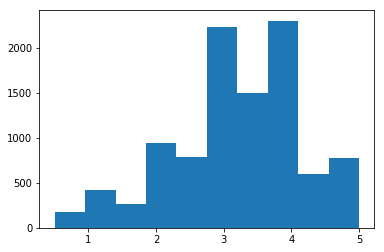

1.18714994841


In [195]:
results = []

tt = train[:10000].copy()

for user_id, group in tt.groupby("userId2"):
    start_time = time.time()
    uvec = U[user_id, :] * S
    movie_ids = group["movieId"] - 1    
    results.append((user_id, movie_ids, uvec.dot(Vt[:, movie_ids])))

    
res2 = {}
for r in results:
    for m, ri in zip(r[1], r[2]):
        res2[(int(r[0]), int(m))] = ri
        
prating = []

for i, row in tt.iterrows():
    prating.append(res2[(int(row.userId2), int(row.movieId) - 1)])
    


prating = reshape(np.array(prating), hist_shape, hist_xs)
    
tt["rating2"] = np.array(prating)

print(tt.rating.mean())

plt.hist(tt.rating)
plt.show()

tt.head()

print((((tt["rating"] - tt["rating2"]) ** 2).sum() / len(tt)) ** 0.5)

In [203]:
results = []

for user_id, group in test.groupby("userId2"):
    start_time = time.time()
    uvec = U[user_id, :] * S
    movie_ids = group["movieId"] - 1    
    results.append((user_id, movie_ids, uvec.dot(Vt[:, movie_ids])))


In [204]:
res2 = {}
for r in results:
    for m, ri in zip(r[1], r[2]):
        res2[(int(r[0]), int(m))] = ri

In [205]:
prating = []

for i, row in test.iterrows():
    prating.append(res2[(int(row.userId2), int(row.movieId) - 1)])

In [206]:
prating = np.array(prating)
test["rating"] = prating

In [183]:
answer = pd.read_csv('data/baseline.csv')
print(answer.rating.mean())
answer["rating"] = test["rating"]
print(answer.rating.mean())
answer.to_csv("to_send.csv", index=False)


3.65559799577
0.822592502529


In [184]:
train.rating.mean()

3.5207268919475605

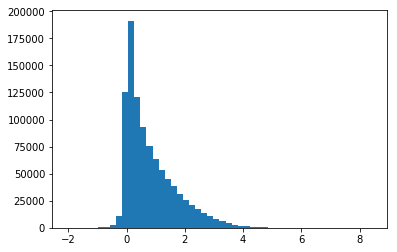

In [185]:
plt.hist(answer.rating, bins=50)
plt.show()

In [186]:
answer.rating.mean()

0.82259250252904903

In [20]:
import numpy as np

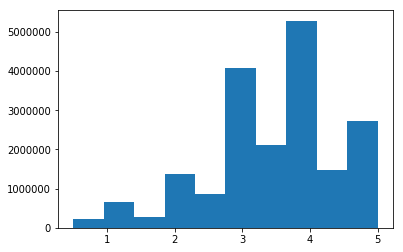

In [21]:
a = plt.hist(train.rating, bins=10)
plt.show()

In [30]:
hist_shape = a[0] / a[0].sum()
display(hist_shape)
hist_xs = np.arange(0.5, 5.1, 0.5)
display(hist_xs)
hist_pairs = list(zip(hist_xs, hist_shape))
display(hist_pairs)

array([ 0.01195515,  0.03404094,  0.01410676,  0.07200356,  0.04487432,
        0.21409095,  0.11150101,  0.27782659,  0.07696208,  0.14263865])

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

[(0.5, 0.011955146192344156),
 (1.0, 0.034040943228122976),
 (1.5, 0.014106759063166972),
 (2.0, 0.072003562741061816),
 (2.5, 0.044874318240015171),
 (3.0, 0.21409095013598253),
 (3.5, 0.11150100504492003),
 (4.0, 0.27782659121506437),
 (4.5, 0.076962075351363401),
 (5.0, 0.14263864878795859)]

In [37]:
def remap(x, l, u, nl, nu):
    return nl + (x - l) / (u - l) * (nu - nl)
    
def reshape(values, hist_shape, hist_xs):
    enuv = list(enumerate(values))
    values = sorted(enuv, key=lambda x: x[1])
    bounds = [0] + [int(len(enuv) * x) for x in hist_shape.cumsum()]
    bounds[-1] = len(values)
    for i in range(len(bounds) - 1):
        l = hist_xs[i - 1] if i != 0 else hist_xs[i]
        u = hist_xs[i + 1] if i != len(bounds) - 2 else hist_xs[i]
        m = hist_xs[i]
        mid = (bounds[i] + bounds[i + 1]) // 2
        for j in range(bounds[i], bounds[i + 1]):
            values[j] = (values[j][0], m)
        
#         for j in range(bounds[i], mid):
#             values[j] = (values[j][0], remap(values[j][1], values[bounds[i]][1], values[mid - 1][1], l, m))
#         for j in range(mid, bounds[i + 1]):
#             values[j] = (values[j][0], remap(values[j][1], values[mid][1], 
#                                              values[bounds[i + 1] - 1][1], m, u))
    enuv = sorted(values)
    return np.array([x[1] for x in enuv])
    

In [209]:
prating = np.array(prating)


prating2 = reshape(prating, hist_shape, hist_xs)


print(list(zip(prating[:100], prating2[:100])))

test["rating"] = prating2

answer = pd.read_csv('data/baseline.csv')
print(answer.rating.mean())
answer["rating"] = test["rating"]
print(answer.rating.mean())
answer.to_csv("to_send.csv", index=False)

[(1.8841814237484198, 4.6419229434025029), (0.50949306476392631, 3.5071885106837422), (2.4357414779557973, 4.5), (0.046958243747968462, 2.0048590208577846), (1.2060659473415989, 4.0434118105124011), (0.18028532523194474, 2.5020815785412589), (0.17256062852209667, 2.5042129170261385), (1.4638445597770198, 4.0276964246104772), (0.61358712696428219, 3.5663330274438652), (1.4687966998654725, 4.0264130124665787), (3.2683751522362483, 4.5), (0.88734719502798787, 3.5013654898096362), (0.85670521522521714, 3.5086373099479937), (2.1487729657886634, 4.5616479220125381), (0.15669067244181251, 2.5085916323877568), (3.8677157954343087, 4.5), (0.52264672234370546, 3.5045097853593736), (1.2123543866749205, 4.041922137258954), (2.209280366810134, 4.5432904459050407), (0.031595481190452961, 2.0042487677882237), (1.0520575549950719, 4.0798949775947957), (1.3597620059024011, 4.0070026324218819), (1.6173154289332794, 4.5378899731369691), (1.2851192466628154, 4.0246848133429154), (0.65745082499448926, 3.55

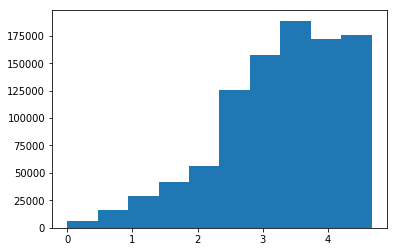

In [211]:
plt.hist(answer.rating)
plt.show()

In [215]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


In [237]:
!vw --version

8.1.1


In [240]:
movie_to_compress_id = {}
n = len(movie_to_compress_id)
def add_id_to_compress(i):
    movie_to_compress_id.setdefault(i, n)

for i, row in train.iterrows():
    add_id_to_compress(row.movieId)
    
for i, row in test.iterrows():
    add_id_to_compress(row.movieId)
        
ui2 = []

for i, row in test.iterrows():
    ui2.append(movie_to_compress_id[row.movieId])

test["movieId2"] = np.array(ui2)

display(test.head())

,movieId,userId,userId2,rating,movieId2
0,939,3128775406573976678,0,4.641923,0
1,19,6058877902987009152,1,3.507189,1
2,1213,2787275058272728238,2,4.500000,2
3,1141,14199414671932452776,3,2.004859,3
4,2935,5958052843391945803,4,4.043412,4


In [241]:
ui2 = []

for i, row in train.iterrows():
    ui2.append(movie_to_compress_id[row.movieId])

train["movieId2"] = np.array(ui2)
display(train.head())

In [242]:
display(train.head())

,rating,movieId,userId,userId2,movieId2
0,3.0,2158,10953099004185006703,731,9854
1,3.5,12959,10953099004185006703,731,8608
2,3.5,7808,10953099004185006703,731,11555
3,4.0,9049,4762492897681260571,3052,10295
4,3.0,12363,2110017552365950661,125,9988


In [243]:
train[["userId2", "movieId2", "rating"]].to_csv("ml20m_train.csv", header=False, index=False)
test[["userId2", "movieId2", "rating"]].to_csv("ml20m_test.csv", header=False, index=False)

In [2]:
# это все жутко долго

with open("compress.cpp", "w") as f:
    f.write(R"""

#include <cstdio>
#include <cstdlib>
#include <unordered_map>

using ui32 = uint32_t;

int main() {
    char line[1000];

    FILE *input, *output;

    std::unordered_map<uint64_t, uint32_t> users;
    std::unordered_map<uint32_t, uint32_t> movies;

    std::unordered_map<uint32_t, uint32_t> movieCounts;
    std::unordered_map<uint32_t, double> movieSums;
    {
        FILE* input = fopen("data/train.csv", "rt");
        FILE* output = fopen("data/user_average.csv", "wt");

        // header
        fgets(line, sizeof(line), input);
        fputs(line, output);

        double rating;
        uint32_t mId;
        uint64_t uId;
        while (fscanf(input, "%lf,%u,%llu\n", &rating, &mId, &uId) == 3) {
            movieCounts[mId]++;
            movieSums[mId] += rating;
        }

        fclose(input);
        fclose(output);
    }


    std::unordered_map<uint32_t, uint32_t> userCounts;
    std::unordered_map<uint32_t, double> userSum;

    {
        FILE* input = fopen("data/train.csv", "rt");
        FILE* output = fopen("data/train2.csv", "wt");
        FILE* output3 = fopen("data/train3.csv", "wt");
        FILE* outputUA = fopen("data/user_average.csv", "wt");
        FILE* outputVW = fopen("data/train2vw.csv", "wt");

        // header
        fgets(line, sizeof(line), input);
        fputs(line, output);

        double rating;
        uint32_t mId;
        uint64_t uId;
        while (fscanf(input, "%lf,%u,%llu\n", &rating, &mId, &uId) == 3) {
            if (movieCounts[mId] >= 5) {
                ui32 cuId = movies.emplace(mId, movies.size()).first->second;
                ui32 cmId = users.emplace(uId, users.size()).first->second;

                userCounts[cuId]++;
                userSum[cuId] += rating;

                fprintf(output, "%0.1lf,%u,%u\n", rating, cmId, cuId);
                fprintf(output3, "%u,%u,%0.1lf\n", cuId, cmId, rating);
                fprintf(outputVW, "%0.1lf |u %u |i %u\n", rating, cuId, cmId);
            }
        }

        for (auto mp : userCounts) {
            fprintf(outputUA, "%u,%0.1lf\n", mp.first, userSum[mp.first] / mp.second);
        }

        fclose(input);
        fclose(output);
        fclose(output3);
        fclose(outputVW);
        fclose(outputUA);
    }

    {
        FILE* input = fopen("data/test.csv", "rt");
        FILE* output = fopen("data/test2.csv", "wt");

        FILE* outputWA = fopen("data/test2wa.csv", "wt");

        // header
        fgets(line, sizeof(line), input);
        fputs(line, output);

        double rating;
        uint32_t mId;
        uint64_t uId;
        while (fscanf(input, "%u,%llu\n", &mId, &uId) == 2) {
            ui32 cuId = movies.emplace(mId, movies.size()).first->second;
            ui32 cmId = users.emplace(uId, users.size()).first->second;
            fprintf(output, "%u,%u\n", cmId, cuId);
            fprintf(outputWA, "%u,%u,%0.4lf\n", cmId, cuId, movieSums[mId] / movieCounts[mId]);
        }

        fclose(input);
        fclose(output);

        fclose(outputWA);
    }


}



    """)
    


!g++ --std=c++11 -O3 compress.cpp -o compress
!./compress 


compress.cpp: In function ‘int main()’:
compress.cpp:30:66: warning: format ‘%llu’ expects argument of type ‘long long unsigned int*’, but argument 5 has type ‘uint64_t* {aka long unsigned int*}’ [-Wformat=]
         while (fscanf(input, "%lf,%u,%llu\n", &rating, &mId, &uId) == 3) {
                                                                  ^
compress.cpp:51:66: warning: format ‘%llu’ expects argument of type ‘long long unsigned int*’, but argument 5 has type ‘uint64_t* {aka long unsigned int*}’ [-Wformat=]
         while (fscanf(input, "%lf,%u,%llu\n", &rating, &mId, &uId) == 3) {
                                                                  ^
compress.cpp:78:53: warning: format ‘%llu’ expects argument of type ‘long long unsigned int*’, but argument 4 has type ‘uint64_t* {aka long unsigned int*}’ [-Wformat=]
         while (fscanf(input, "%u,%llu\n", &mId, &uId) == 2) {
                                                     ^
compress.cpp:24:41: warning: ignoring return value

In [8]:
import pandas as pd
df_train = pd.read_csv('data/train2.csv')
df_train = df_train.sort_values(['userId', 'movieId'])
df_train.head(3)

,rating,movieId,userId
0,3.0,0,0
15657477,2.5,8,0
976912,2.0,21,0


In [9]:
df_train[["userId", "movieId", "rating"]].to_csv('data/train2s.csv', index=False)

In [10]:
!awk -F"," '{printf "%f |u %d |i %d\n", $3,$1+1,$2+1}' < data/train2s.csv > data/train2vw.csv

In [11]:
!cat data/train2vw.csv | vw /dev/stdin -b 18 -q ui --rank 30 --l2 0.001 --learning_rate 0.015 \
    --passes 5 --decay_learning_rate 0.97 --power_t 0 \
    --loss_function squared -f movielens.reg --cache_file movielens.cache

creating quadratic features for pairs: ui 
using l2 regularization = 0.001
final_regressor = movielens.reg
Num weight bits = 18
learning rate = 0.015
initial_t = 1
power_t = 0
decay_learning_rate = 0.97
using cache_file = movielens.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
22.288675 22.288675            1            1.0   5.0000   0.2789       63
17.776968 13.265260            2            2.0   4.0000   0.3578       63
14.530089 11.283211            4            4.0   4.5000   0.4959       63
14.231754 13.933419            8            8.0   4.5000   0.7217       63
9.850208 5.468663           16           16.0   3.5000   1.1505       63
8.271773 6.693338           32           32.0   3.5000   1.8824       63
6.229864 4.187955           64           64.0   5.0000   3.1649       63
3.816582 1.403300          128       

In [2]:
import pandas as pd
answer = pd.read_csv('data/baseline.csv')
test_wa = pd.read_csv('data/test2.csv')
test_wa['rating'] = answer['rating']
test_wa.to_csv("test_wa.csv", index=False, header=False)


In [3]:
!awk -F"," '{printf "%f |u %d |i %d\n", $3,$1+1,$2+1}' < test_wa.csv | \
  vw /dev/stdin -i movielens.reg -t

creating quadratic features for pairs: ui 
only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = /dev/stdin
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.427959 0.427959            1            1.0   4.0674   3.4132       63
0.297160 0.166361            2            2.0   3.2720   2.8641       63
0.389500 0.481840            4            4.0   3.5760   2.6696       63
0.595496 0.801491            8            8.0   3.9315   3.1788       63
0.698220 0.800945           16           16.0   4.2100   3.1328       63
0.730499 0.762778           32           32.0   3.7609   3.7544       63
0.700302 0.670104           64           64.0   4.1327   4.3258       63
0.637065 0.573827          128          128.0   3.6066   3.4273       63
0.551125 0.465186          256          256.0   3.8800   3.9482       63
0.596371 0.6

In [5]:
!awk -F"," '{printf "%f |u %d |i %d\n", $3,$1+1,$2+1}' < test_wa.csv | \
  vw /dev/stdin -i movielens.reg -t -p /dev/stdout > my_predictions.csv

creating quadratic features for pairs: ui 
only testing
predictions = /dev/stdout
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = /dev/stdin
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.427959 0.427959            1            1.0   4.0674   3.4132       63
0.297160 0.166361            2            2.0   3.2720   2.8641       63
0.389500 0.481840            4            4.0   3.5760   2.6696       63
0.595496 0.801491            8            8.0   3.9315   3.1788       63
0.698220 0.800945           16           16.0   4.2100   3.1328       63
0.730499 0.762778           32           32.0   3.7609   3.7544       63
0.700302 0.670104           64           64.0   4.1327   4.3258       63
0.637065 0.573827          128          128.0   3.6066   3.4273       63
0.551125 0.465186          256          256.0   3.8800   3.

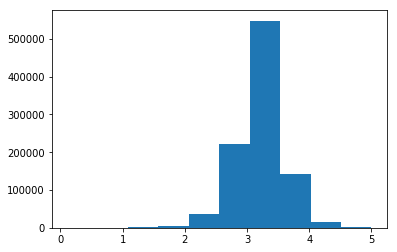

In [10]:
predictions = pd.read_csv("my_predictions.csv", names=["rating"])
import matplotlib.pylab as plt
plt.hist(predictions.rating)
plt.show()

In [13]:
train = pd.read_csv('data/train.csv')

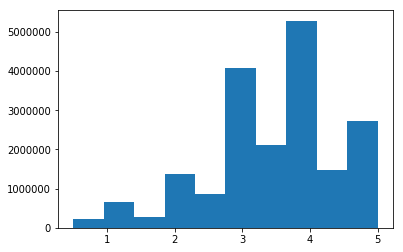

In [17]:
plt.hist(train.rating)
plt.show()

In [116]:
#test['rating'] = reshape(np.array(predictions.rating), hist_shape, hist_xs)
test['rating'] = np.array(predictions.rating)
r = np.array(test['rating'])
test['rating'] = np.minimum(np.ones_like(r) * 5, np.maximum(np.ones_like(r) * 0.0, r))

#float(test.groupby("userId").mean().loc[2, "rating"])
old_avgs = train.groupby("userId").mean()
new_avgs = test.groupby("userId").mean()
avg_m_rate = train.groupby("movieId").mean()
avgs_delta = {}
user_ans = {}
for i, row in test.iterrows():
    try:
        avgs[row.userId] = new_avgs.loc[row.userId, "rating"] - old_avgs.loc[row.userId, "rating"]
    except:
        try:
            user_ans[row.userId] = avg_m_rate.loc[row.movieId, "rating"]
        except:
            print('?')
    
display(avgs_delta)

display(list(zip(answer.rating, test.rating))[:20])

?
?


{}

[(4.0673664539699992, 3.4131800000000001),
 (3.2719767155199997, 2.8641030000000001),
 (3.9301689773200001, 3.5531800000000002),
 (3.5759671979800003, 2.6695679999999999),
 (3.5827481591300003, 2.238038),
 (2.6603618418199999, 3.5700529999999997),
 (3.0653897300200001, 3.125089),
 (3.9315379093699998, 3.1787970000000003),
 (3.2886601140700003, 3.7589129999999997),
 (3.6612360565599995, 3.2988749999999998),
 (3.5193422557499998, 3.4043940000000004),
 (3.4838757224100001, 4.3488680000000004),
 (3.4150726541199998, 2.6530019999999999),
 (4.15008492678, 3.2249849999999998),
 (4.2428157845000003, 2.6005790000000002),
 (4.2099699582900003, 3.1328499999999999),
 (3.1799613098999999, 2.9714900000000002),
 (3.6205170303600003, 2.7959860000000001),
 (2.3907023814200001, 4.1884750000000004),
 (3.5745597309599995, 3.6311529999999999)]

In [118]:
c = 0
ui = []
for i, row in test.iterrows():
    if row.userId > 18284:
        ui.append(float(user_ans[row.userId]))
    else:
        ui.append(row.rating)
test["rating"] = ui

{0.0: 3.8117736230419403,
 1.0: 2.9613919227838457,
 2.0: 3.7142857142857144,
 3.0: 3.7764863656683056,
 4.0: 2.3806818181818183,
 5.0: 3.7000000000000002,
 6.0: 2.6666666666666665,
 7.0: 3.906193243734108,
 8.0: 3.0333333333333332,
 9.0: 3.9688814129520606,
 10.0: 3.8131868131868134,
 11.0: 3.8199052132701423,
 12.0: 3.9847250509164969,
 13.0: 3.25,
 14.0: 3.2747603833865813,
 15.0: 4.1239463601532567,
 16.0: 3.7684782608695651,
 17.0: 3.0328947368421053,
 18.0: 2.9676354029062089,
 19.0: 3.3999999999999999,
 20.0: 3.1904761904761907,
 21.0: 3.6977299880525689,
 22.0: 3.8099783861671468,
 23.0: 3.1607142857142856,
 24.0: 2.6202547452547451,
 25.0: 1.8922651933701657,
 26.0: 3.6183510638297873,
 27.0: 3.6150951748561311,
 28.0: 3.4157894736842107,
 29.0: 1.9909485879797248,
 30.0: 3.604679802955665,
 31.0: 3.543181818181818,
 32.0: 3.411111111111111,
 33.0: 2.7431302270011946,
 34.0: 3.0,
 35.0: 3.0096153846153846,
 36.0: 4.0027565733672601,
 37.0: 3.392156862745098,
 38.0: 2.351694915

In [119]:
test.head()

,movieId,userId,rating
0,1499,46281,3.568203
1,1715,51432,2.126747
2,2748,26152,2.534884
3,4296,14343,2.669568
4,2507,11687,2.238038


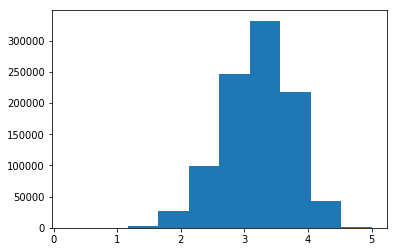

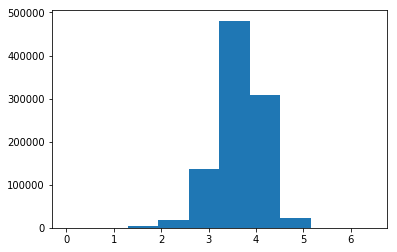

In [120]:
plt.hist(test.rating)
plt.show()
plt.hist(answer.rating)
plt.show()

In [61]:
!head -n 2 ./ml20m_train_prepared.csv

3.000000 |u 731 |i 9853
3.500000 |u 731 |i 8607


In [121]:
ans = answer.copy()

ans.rating = test.rating

print((((answer.rating - ans.rating) ** 2).sum()) ** 0.5)

ans.to_csv("to_send.csv", index=False)

826.135460319


In [122]:
!head to_send.csv
!head data/baseline.csv

Id,rating
1,3.5682031103616265
2,2.126746506986028
3,2.5348837209302326
4,2.669568
5,2.238038
6,3.5700529999999997
7,3.125089
8,3.0493565369991225
9,3.7589129999999997
Id,rating
1,4.06736645397
2,3.27197671552
3,3.93016897732
4,3.57596719798
5,3.58274815913
6,2.66036184182
7,3.06538973002
8,3.93153790937
9,3.28866011407


In [64]:
(0, 1) + (2, 0)

(0, 1, 2, 0)

In [68]:
def get_ua(t):
    s = t.groupby("userId").sum()
    c = t.groupby("userId").count()
    s.rating = s.rating
    

test.groupby("userId").sum()[["user"]] / test.groupby("userId").count()["rating"]

MemoryError: 

In [115]:
float(test.groupby("userId").mean().loc[2, "rating"])

2.8311944285714286